In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Compose, Normalize, ConvertImageDtype

device = torch.device("cuda")

#Part (i) - Download and Process Dataset

In [3]:
#Download Dataset
mnist_ds = MNIST('./', train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
x_mnist, y_mnist = mnist_ds.data, mnist_ds.targets

In [5]:
print(x_mnist.shape, y_mnist.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


In [48]:
# Use 1000 images of each MNIST digit
x = []
y = []
for i in range(10):
    x.append(x_mnist[y_mnist==i][:1000])
    y.append(y_mnist[y_mnist==i][:1000])
x = torch.concat(x)
y = torch.concat(y)
print(x.shape, y.shape)

torch.Size([10000, 28, 28]) torch.Size([10000])


In [49]:
# Sub-sample the MNIST images to 14 × 14 size
transform = Resize((14, 14))
x = transform(x)
print(x.shape)

torch.Size([10000, 14, 14])


In [50]:
#Flatten
x = x.flatten(start_dim=1)
print(x.shape)

torch.Size([10000, 196])


In [51]:
# binarize the MNIST dataset for this problem: if a pixel is greater than 128 set it to 1, else set it to zero
x = (x > 128).float()
print("Min: ", x.min().item(), " Max: ", x.max().item())

Min:  0.0  Max:  1.0


In [52]:
# Create Dataloader
ds = TensorDataset(x)
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=8)

In [53]:
# Test Dataloader
for data in dl:
    print(data[0].shape)
    break

torch.Size([128, 196])


#Part (ii) - Train the auto-encoder

##Define Encoder-Decoder Architecture & Objective

In [35]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(14 * 14, 128)
        self.tanh = nn.Tanh()
        self.mu = nn.Linear(128, 8)
        self.var = nn.Linear(128, 8)
        # self.l2 = nn.Linear(128, 16)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)

        # x = self.l2(x)
        mu = self.mu(x)
        var = self.var(x)
        return mu, var

In [32]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(8, 128)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(128, 196)
        self.sig = nn.Sigmoid()
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
    
    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        x = self.sig(x)
        return x

In [73]:
def get_gauss_liklihood(mean, logscale, sample):
    scale = torch.exp(logscale)
    distribution = torch.distributions.Normal(mean, scale)
    log_pxz = distribution.log_prob(sample).sum(1)
    return log_pxz

In [34]:
def get_kl_divergence(z, mu, std):
    p = torch.distributions.Normal(torch.zeros(mu.shape), torch.ones(std.shape))
    q = torch.distributions.Normal(mu, std)
    
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    kl = (log_qzx - log_pz).sum(dim=-1)
    return kl

## Train

In [101]:
epochs = 200
encoder = Encoder()
decoder = Decoder()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

kl_losses = []
reconstruction_losses = []
losses = []

for e in range(epochs):
    for data in dl:
        img = data[0]

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        mu, var = encoder(img)

        std = torch.exp(var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        dec_pred = decoder(z)
        recon_loss = get_gauss_liklihood(dec_pred, decoder.log_scale, img).mean()
        reconstruction_losses.append(recon_loss.item())

        kl_loss = get_kl_divergence(z, mu, std).mean()
        kl_losses.append(kl_loss.item())

        loss = (kl_loss - recon_loss).mean()
        loss.backward()
        losses.append(loss.item())

        enc_optimizer.step()
        dec_optimizer.step()

#Part (iii) - Plot Term 1 and Term 2

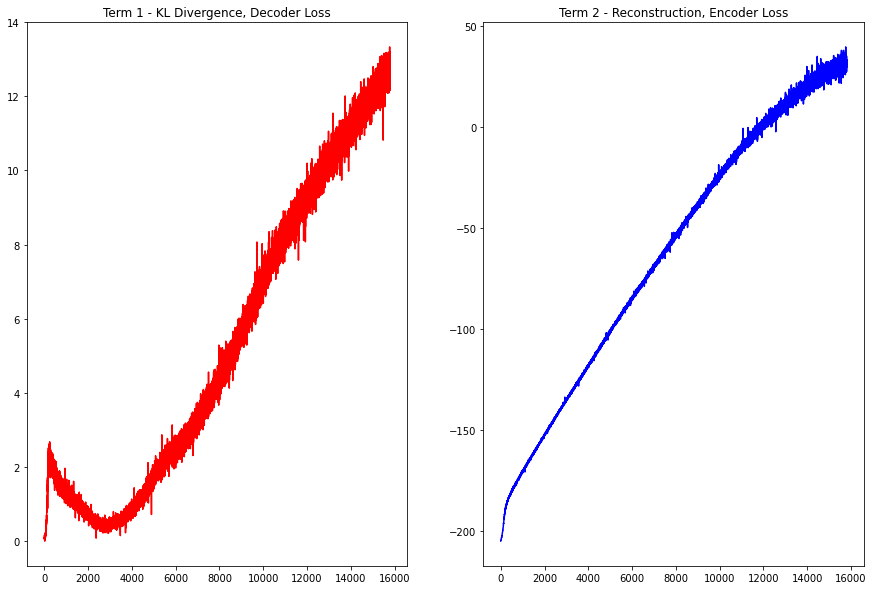

In [102]:
fig, (axs1, axs2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(15)

axs1.set_title("Term 1 - KL Divergence, Decoder Loss")
axs2.set_title("Term 2 - Reconstruction, Encoder Loss")
axs1.plot(kl_losses, color='red') #Term 1 (Decoder Loss, kl divergence term)
axs2.plot(reconstruction_losses, color='blue') #Term 2 (Encoder Loss, reconstruction term)

#Part (iv) - Decoder and Encoder Image Plots

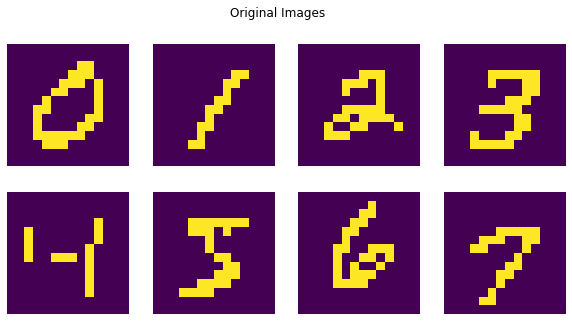

In [103]:
#Original Images
examples = []
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
c = 0
fig.suptitle("Original Images")
for i in range(2):
    for j in range(4):
        example = x[c * 1000].reshape(14, 14)
        examples.append(example)
        axs[i][j].axis("off")
        axs[i][j].imshow(example)
        c += 1

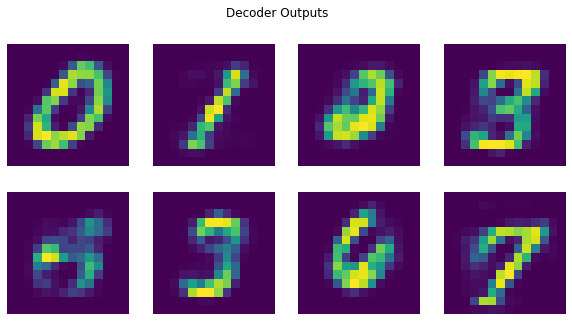

In [104]:
encoder.eval()
decoder.eval()

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle("Decoder Outputs")

for i, example in enumerate(examples):
    mu, var = encoder(example.reshape(1, -1))

    std = torch.exp(.5 * var)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    dec_val = decoder(z)
    dec_val = dec_val.reshape((14, 14))
    axs[i // 4][i % 4].axis("off")

    axs[i // 4][i % 4].imshow(dec_val.detach().numpy())

Ayyy that looks pretty good!

#Part (v) - Sample from Generative Model Directly

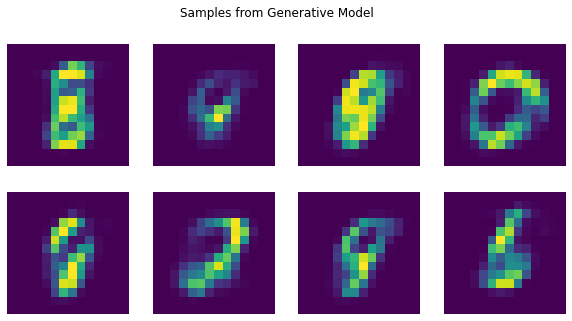

In [105]:
shape = (8, 8) #batch, z size
z = torch.normal(0, 1, size=shape)
dec_val = decoder(z)
dec_val = dec_val.reshape((shape[0], 14, 14))

encoder.eval()
decoder.eval()

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle("Samples from Generative Model")
for i in range(shape[0]):
    axs[i // 4][i % 4].axis("off")
    axs[i // 4][i % 4].imshow(dec_val[i].detach().numpy())

#Part (iv) - Compute Validation Performance of a Generative Model

In [106]:
epochs = 200
encoder = Encoder()
decoder = Decoder()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

train_recon_losses = []
val_recon_losses = []

for e in range(epochs):
    for data in dl: #Approximately 100 updates per cycle
        img = data[0]

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        mu, var = encoder(img)

        std = torch.exp(var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        dec_pred = decoder(z)
        recon_loss = get_gauss_liklihood(dec_pred, decoder.log_scale, img).mean()
        train_recon_losses.append(recon_loss.item())

        kl_loss = get_kl_divergence(z, mu, std).mean()

        loss = (kl_loss - recon_loss).mean()
        loss.backward()

        enc_optimizer.step()
        dec_optimizer.step()
    
    #Validation Loss
    with torch.no_grad():
        synth_img = torch.randint(0, 2, (100, 14 * 14)).float()
        mu, var = encoder(synth_img)
        q = torch.distributions.Normal(mu, torch.exp(var / 2))
        z = q.rsample()
        dec_pred = decoder(z)
        recon_loss = get_gauss_liklihood(dec_pred, decoder.log_scale, synth_img).mean()
        val_recon_losses.append(recon_loss.item())
        

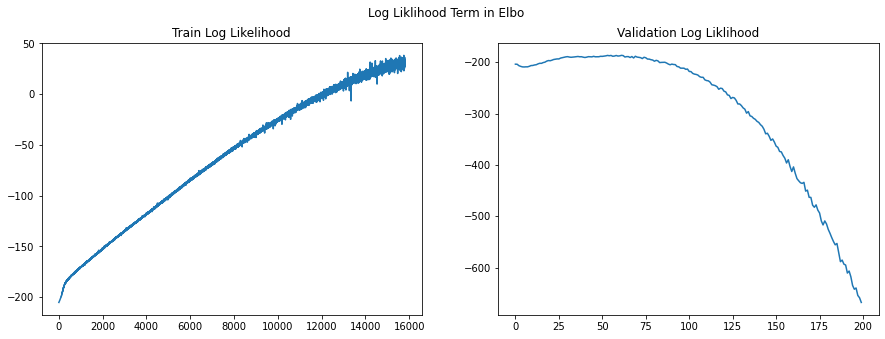

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Log Liklihood Term in Elbo")
ax1.set_title("Train Log Likelihood")
ax2.set_title("Validation Log Liklihood")
ax1.plot(train_recon_losses)
ax2.plot(val_recon_losses)

Clearly there is an overfitting towards the end, performing better on the train dataset but poorly on the synthesized images. If the images were synthesized from a similar distrubution of the training dataset, then the validation would likely be better.